In [1]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from barnacle.tensors import SparseCPTensor
from matplotlib import pyplot as plt
from pathlib import Path
from tlviz.factor_tools import factor_match_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)


# import data

In [4]:
# read in aligned model datasets

datapath = Path('../../data/5-models/')

pro_ds = xr.open_dataset(datapath / 'pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / 'syn-aligned-models.nc')

pro_ds

<xarray.Dataset>
Dimensions:          (Bootstrap: 100, Replicate: 3, Component: 15,
                      Ortholog: 5023, Clade: 3, SampleName: 74)
Coordinates:
  * Bootstrap        (Bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * Replicate        (Replicate) object 'A' 'B' 'C'
  * Component        (Component) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * Ortholog         (Ortholog) int64 60000001 60000002 ... 60040287 60040292
  * Clade            (Clade) object 'HLI' 'HLII' 'LLI'
  * SampleName       (SampleName) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS...
Data variables:
    ComponentWeight  (Bootstrap, Replicate, Component) float64 ...
    GeneWeight       (Bootstrap, Replicate, Component, Ortholog) float64 ...
    TaxonWeight      (Bootstrap, Replicate, Component, Clade) float64 ...
    SampleWeight     (Bootstrap, Replicate, Component, SampleName) float64 ...
    Sample           (Bootstrap, Replicate, SampleName) object ...

In [5]:
# select only "robust" clusters

pro_clusters = [
    'pro2', 'pro5', 'pro6', 'pro7', 'pro8', 'pro9', 'pro10', 'pro11', 'pro12', 'pro13', 'pro14', 'pro15'
]
syn_clusters = [
    'syn4', 'syn5', 'syn6', 'syn7', 'syn8', 'syn9', 'syn10', 'syn11', 'syn12', 'syn13', 'syn14', 'syn15'
]
robust_clusters = pro_clusters + syn_clusters


In [7]:
# pull out median bootstrap weights

# pull out pro gene weight data
pro_gene_df = pro_ds.median(dim=['Bootstrap', 'Replicate']).GeneWeight.T.to_pandas()
pro_gene_df = pro_gene_df.rename(columns=dict(zip(pro_gene_df.columns, [f"pro{i}" for i in pro_gene_df.columns])))
# select only robust components
pro_gene_df = pro_gene_df.loc[:, pro_clusters]

# pull out pro sample weight data
pro_sample_df = pro_ds.median(dim=['Bootstrap', 'Replicate']).SampleWeight.T.to_pandas()
pro_sample_df = pro_sample_df.rename(columns=dict(zip(pro_sample_df.columns, [f"pro{i}" for i in pro_sample_df.columns])))
# select only robust components
pro_sample_df = pro_sample_df.loc[:, pro_clusters]

# pull out pro taxon weight data
pro_taxon_df = pro_ds.median(dim=['Bootstrap', 'Replicate']).TaxonWeight.T.to_pandas()
pro_taxon_df = pro_taxon_df.rename(columns=dict(zip(pro_taxon_df.columns, [f"pro{i}" for i in pro_taxon_df.columns])))
# select only robust components
pro_taxon_df = pro_taxon_df.loc[:, pro_clusters]

# pull out syn gene weight data
syn_gene_df = syn_ds.median(dim=['Bootstrap', 'Replicate']).GeneWeight.T.to_pandas()
syn_gene_df = syn_gene_df.rename(columns=dict(zip(syn_gene_df.columns, [f"syn{i}" for i in syn_gene_df.columns])))
# select only robust components
syn_gene_df = syn_gene_df.loc[:, syn_clusters]

# pull out syn sample weight data
syn_sample_df = syn_ds.median(dim=['Bootstrap', 'Replicate']).SampleWeight.T.to_pandas()
syn_sample_df = syn_sample_df.rename(columns=dict(zip(syn_sample_df.columns, [f"syn{i}" for i in syn_sample_df.columns])))
# select only robust components
syn_sample_df = syn_sample_df.loc[:, syn_clusters]

# pull out syn taxon weight data
syn_taxon_df = syn_ds.median(dim=['Bootstrap', 'Replicate']).TaxonWeight.T.to_pandas()
syn_taxon_df = syn_taxon_df.rename(columns=dict(zip(syn_taxon_df.columns, [f"syn{i}" for i in syn_taxon_df.columns])))
# select only robust components
syn_taxon_df = syn_taxon_df.loc[:, syn_clusters]

syn_taxon_df


Component,syn4,syn5,syn6,syn7,syn8,syn9,syn10,syn11,syn12,syn13,syn14,syn15
Clade,,,,,,,,,,,,
5.1A-CRD2,0.0,0.986246,0.173755,0.097993,0.473963,0.379494,0.462582,0.991777,0.007911,0.235418,0.054460,0.058105
5.1A-II,0.0,0.009302,0.030475,0.694388,0.014716,0.101139,0.230919,0.062715,0.046004,0.610606,0.007599,0.001051
5.1A-III,0.0,0.018133,0.000000,0.483406,0.022695,0.129171,0.145227,0.039274,0.996991,0.223863,0.000493,0.000000
5.1A-IV,1.0,0.046736,0.814975,0.067369,0.112171,0.561699,0.485396,0.047183,0.015931,0.114389,0.122384,0.844337
5.1A-UC-A-EnvC,0.0,0.022519,0.000000,0.509227,0.026522,0.004422,0.088201,0.029840,0.009824,0.077926,0.007104,0.000000
5.1B-CRD1,0.0,0.109123,0.202355,0.044332,0.803951,0.610303,0.572206,0.050588,0.024571,0.225605,0.049185,0.062368
5.1B-I,0.0,0.027751,0.508458,0.029658,0.101947,0.341843,0.306436,0.049674,0.042535,0.095172,0.987686,0.518944


# plot weight correlations

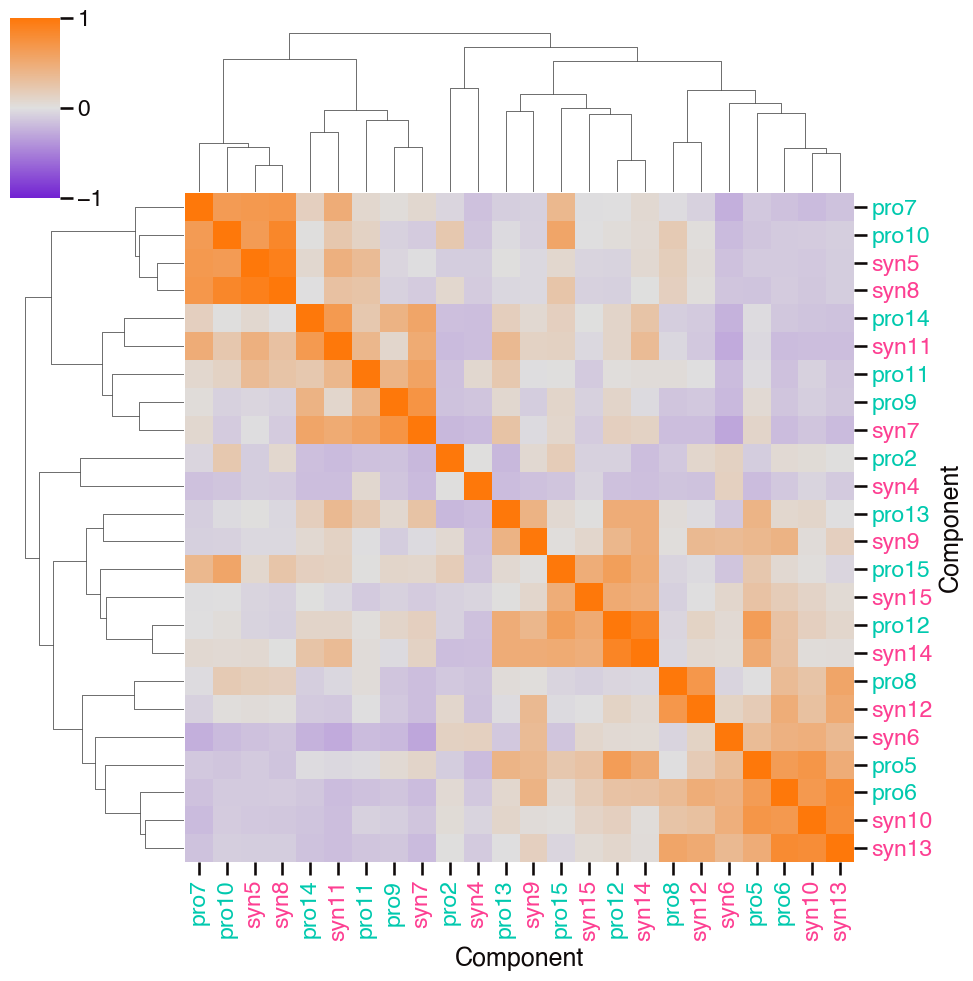

In [8]:
# sample weights correlations

# make joint sample weights df
joint_sampleweights_df = pd.merge(
    pro_sample_df, syn_sample_df, left_index=True, right_index=True, how='outer').fillna(0)

# make correlation matrix
sim_df = pd.DataFrame(
    joint_sampleweights_df.corr(), 
    index=joint_sampleweights_df.columns, 
    columns=joint_sampleweights_df.columns
)

# make heatmap
g = sns.clustermap(
    sim_df, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, 
    xticklabels=True, 
    yticklabels=True
)
# color ticks by pro/syn
for tick_axis in [g.ax_heatmap.axes.get_xticklabels(), g.ax_heatmap.axes.get_yticklabels()]: 
    for tick in tick_axis:
        if tick._text in pro_clusters:
            tick.set_color(sns.color_palette()[2])
        elif tick._text in syn_clusters:
            tick.set_color(sns.color_palette()[3])
# save figure
g.savefig('sampleweights-correlation-heatmap.png')


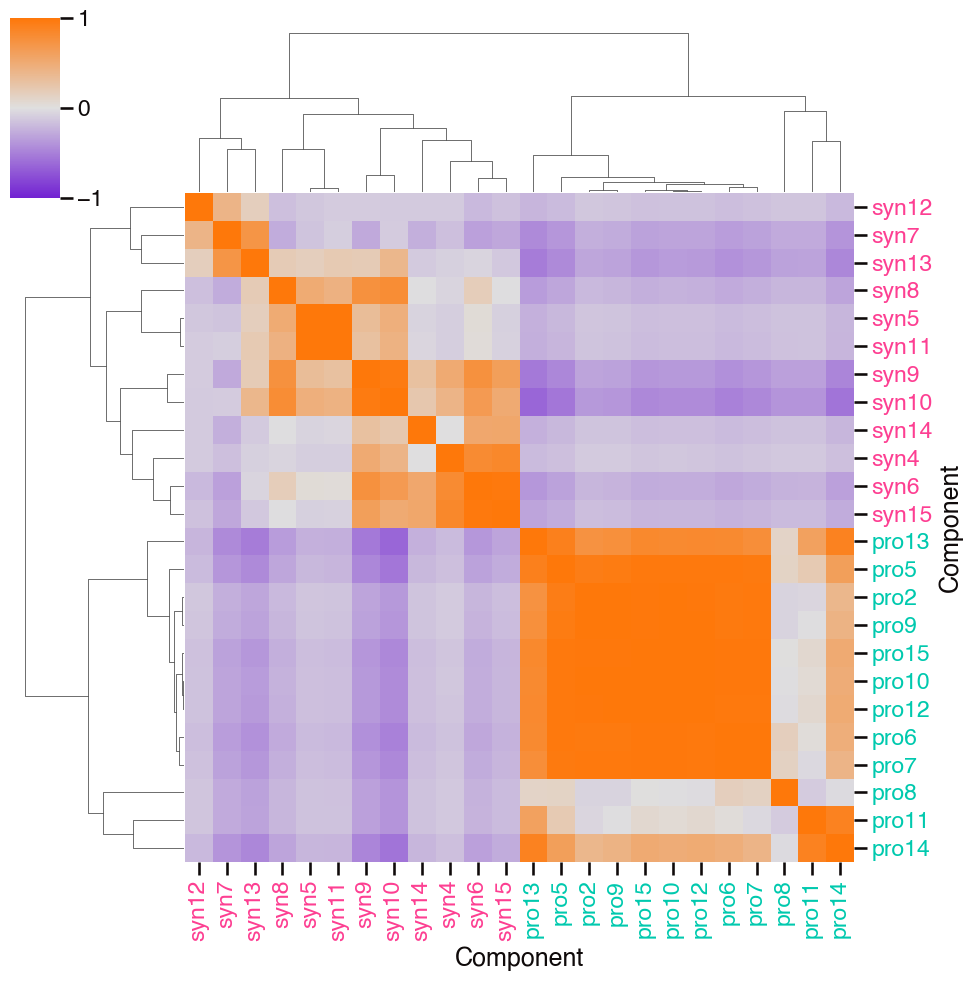

In [9]:
# taxon weights correlation

# make joint taxon weights df
joint_taxonweights_df = pd.merge(
    pro_taxon_df, syn_taxon_df, left_index=True, right_index=True, how='outer').fillna(0)

# make correlation matrix
sim_df = pd.DataFrame(
    joint_taxonweights_df.corr(), 
    index=joint_taxonweights_df.columns, 
    columns=joint_taxonweights_df.columns
)

# make heatmap
g = sns.clustermap(
    sim_df, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, 
    xticklabels=True, 
    yticklabels=True
)
# color ticks by pro/syn
for tick_axis in [g.ax_heatmap.axes.get_xticklabels(), g.ax_heatmap.axes.get_yticklabels()]: 
    for tick in tick_axis:
        if tick._text in pro_clusters:
            tick.set_color(sns.color_palette()[2])
        elif tick._text in syn_clusters:
            tick.set_color(sns.color_palette()[3])
# save figure
g.savefig('taxonweights-correlation-heatmap.png')


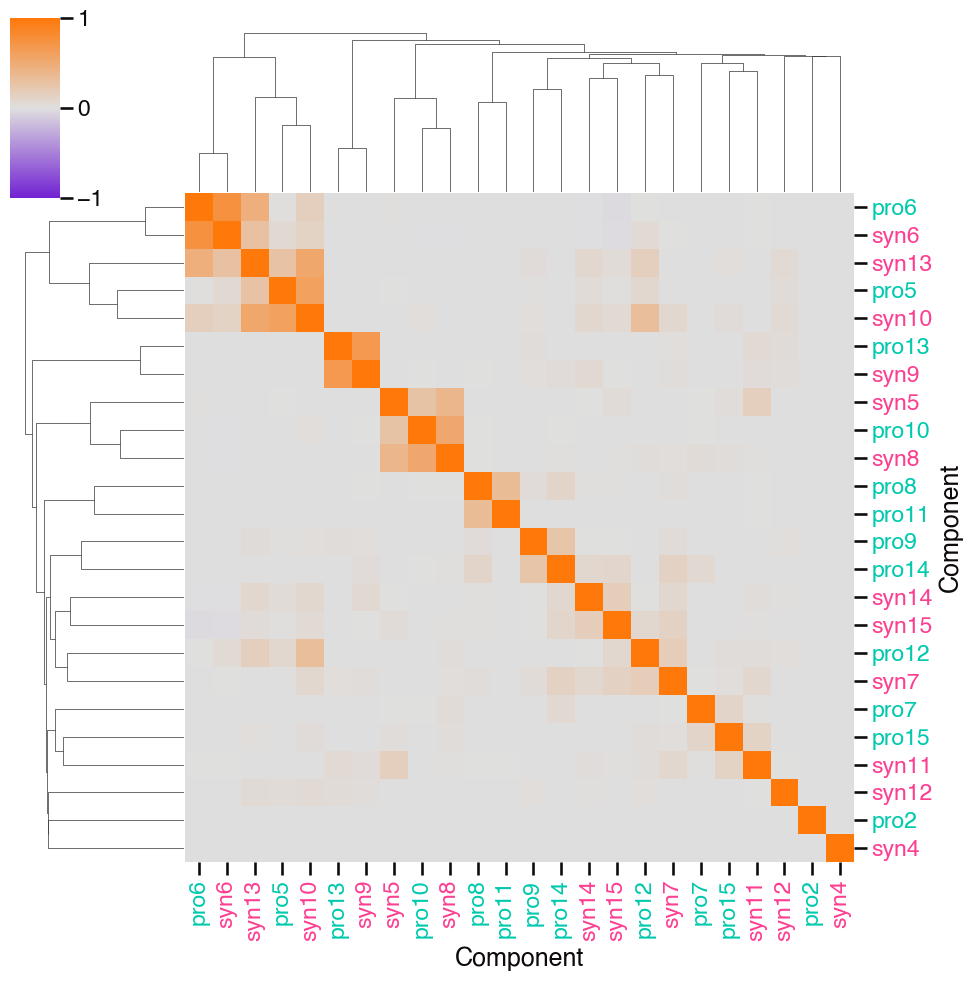

In [10]:
# assemble dataframe of gene cluster members from both pro & syn models

# make joint gene weights df
joint_geneweights_df = pd.merge(
    pro_gene_df, syn_gene_df, left_index=True, right_index=True, how='outer').fillna(0)

# make correlation matrix
sim_df = pd.DataFrame(
    joint_geneweights_df.corr(), 
    index=joint_geneweights_df.columns, 
    columns=joint_geneweights_df.columns
)

# make heatmap
g = sns.clustermap(
    sim_df, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, 
    xticklabels=True, 
    yticklabels=True
)
# color ticks by pro/syn
for tick_axis in [g.ax_heatmap.axes.get_xticklabels(), g.ax_heatmap.axes.get_yticklabels()]: 
    for tick in tick_axis:
        if tick._text in pro_clusters:
            tick.set_color(sns.color_palette()[2])
        elif tick._text in syn_clusters:
            tick.set_color(sns.color_palette()[3])
# save figure
g.savefig('geneweights-correlation-heatmap.png')


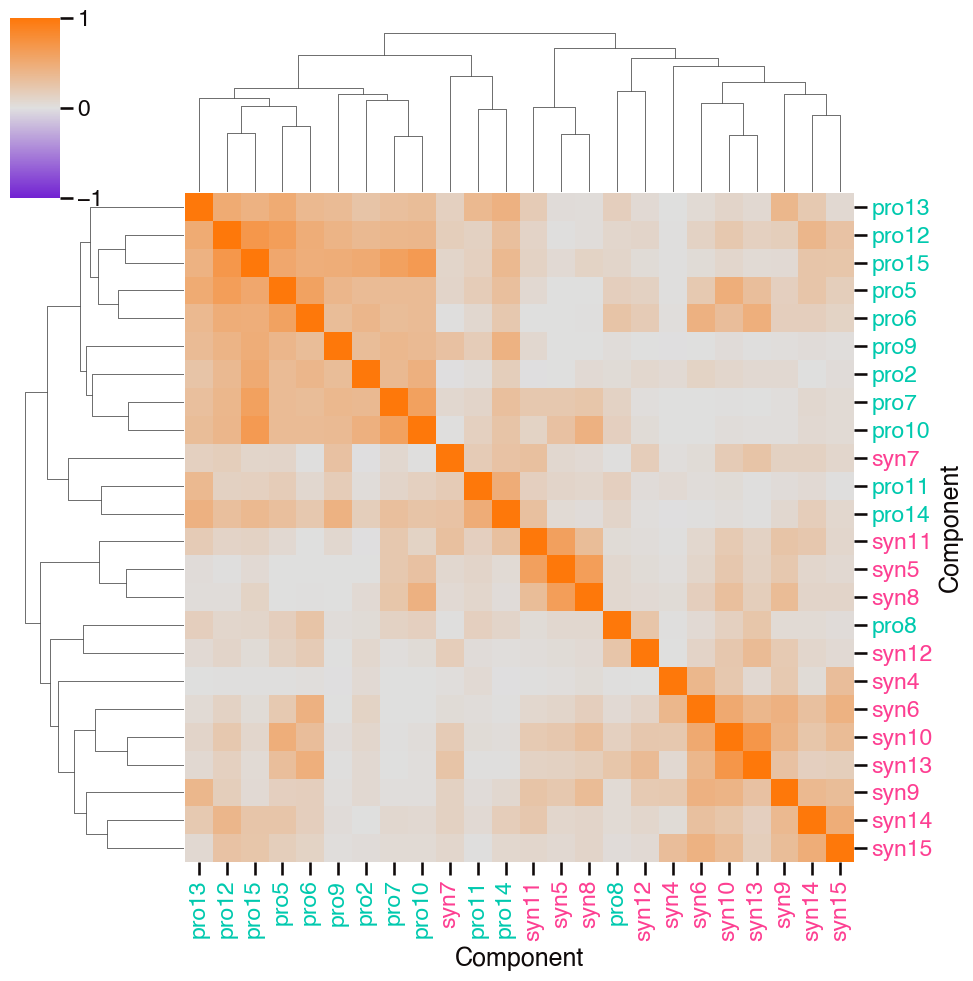

In [11]:
# Combined sample and taxon weights

all_weights_df = pd.concat([
    joint_sampleweights_df, joint_taxonweights_df, joint_geneweights_df]
)

# generate matrix of pairwise cosine similarities
sim_df = pd.DataFrame(
    all_weights_df.corr(), 
    index=all_weights_df.columns, columns=all_weights_df.columns
)

# make heatmap
g = sns.clustermap(
    sim_df, 
    cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, 
    xticklabels=True, 
    yticklabels=True
)
# color ticks by pro/syn
for tick_axis in [g.ax_heatmap.axes.get_xticklabels(), g.ax_heatmap.axes.get_yticklabels()]: 
    for tick in tick_axis:
        if tick._text in pro_clusters:
            tick.set_color(sns.color_palette()[2])
        elif tick._text in syn_clusters:
            tick.set_color(sns.color_palette()[3])
g.savefig('component-correlation-heatmap.png')


# Clustering the clusters w/ PCA

In [ ]:
# run PCA on each component weight matrix

# parameters
n_components = 1
seed = 9481
stat = 'MeanWeight'
threshold = 0.5

embedding_df = pd.DataFrame()
for var in ['gene', 'sample', 'taxon']:
    
    # select input df
    input_df = {
        'gene': joint_geneweights_df, 
        'sample': joint_sampleweights_df, 
        'taxon': joint_taxonweights_df
    }[var]
    input_df = input_df.T
    
    # run PCA
    print('\tRunning PCA on {} with {} components...'.format(var, n_components))
    pca_model = PCA(n_components=n_components, random_state=seed)
    embedding = pca_model.fit_transform(input_df)

    # add in metadata for each metabolite
    result_df = pd.DataFrame(embedding, index=input_df.index, columns=[f"{var} PC1"])
    if len(embedding_df) == 0:
        embedding_df = result_df
    else:
        embedding_df = pd.merge(embedding_df, result_df, left_index=True, right_index=True, how='left')
        
# map cyano info on df
embedding_df = embedding_df.reset_index()
embedding_df['genus'] = ['Prochlorococcus' if c in pro_clusters \
                         else 'Synechococcus' for c in embedding_df.component]

# make plot
x = 'gene PC1'
y = 'sample PC1'
fig, ax = plt.subplots(figsize=[5, 5])
sns.scatterplot(data=embedding_df, x=x, y=y, hue='genus', palette=[sns.color_palette()[i] for i in [2, 3]], 
                alpha=0.5, s=10, ax=ax, legend=False)

# annotate component names
color_map = {'Prochlorococcus': sns.color_palette()[2], 'Synechococcus': sns.color_palette()[3]}
for i, row in embedding_df.iterrows():
    ax.annotate(row['component'], (row[x], row[y]), color=color_map[row['genus']], size=10)
plt.savefig('component-weights-pca-2d.png', bbox_inches='tight')


In [ ]:
# 3d plot

# make plot
x = 'gene PC1'
y = 'sample PC1'
z = 'taxon PC1'
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(projection='3d')

# plot each point
color_map = {'Prochlorococcus': sns.color_palette()[2], 'Synechococcus': sns.color_palette()[3]}
for i, row in embedding_df.iterrows():
    ax.scatter(row[x], row[y], row[z], color=color_map[row['genus']], s=10)
    ax.text(row[x], row[y], row[z], row['component'], color=color_map[row['genus']], size=10)

# label axes
ax.set_xlabel(x);
ax.set_ylabel(y);
ax.set_zlabel(z);

plt.tight_layout()

plt.savefig('component-weights-pca-3d.png', bbox_inches='tight')


# Junk Yard

In [ ]:
# code I worked on but didn't need for any of these figures

# # cluster the pro portion
# linkage = hierarchy.linkage(css_genes_df.loc[pro_labels, pro_labels], optimal_ordering=True)
# dendrogram = hierarchy.dendrogram(linkage, no_plot=True)
# # rearrange pro labels based on dendrogram
# pro_labels = [pro_labels[i] for i in dendrogram['leaves']]

# # cluster the syn portion
# linkage = hierarchy.linkage(css_genes_df.loc[syn_labels, syn_labels], optimal_ordering=True)
# dendrogram = hierarchy.dendrogram(linkage, no_plot=True)
# # rearrange labels 
# syn_labels = [syn_labels[i] for i in dendrogram['leaves']]

# # make heatmap
# sns.heatmap(
#     css_genes_df.loc[pro_labels+syn_labels, pro_labels+syn_labels],  
#     cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, square=True
# )

# pro_cp = SparseCPTensor(
#     (
#         pro_med_ds.componentweights.data, 
#         [
#             joint_geneweights_df.loc[:, pro_labels].to_numpy(), 
#             pro_med_ds.taxonweights.data.T, 
#             pro_med_ds.sampleweights.data.T
#         ]
#     )
# )
# syn_cp = SparseCPTensor(
#     (
#         syn_med_ds.componentweights.data, 
#         [
#             joint_geneweights_df.loc[:, syn_labels].to_numpy(), 
#             syn_med_ds.taxonweights.data.T, 
#             syn_med_ds.sampleweights.data.T
#         ]
#     )
# )


In [ ]:
# # assemble dataframe of gene cluster members from both pro & syn models

# # pro gene weights at 50% bootstrap cutoff (median)
# pro_geneweights_df = pro_ds.median(dim=['bootstrap', 'replicate']).geneweights.T.to_pandas()
# pro_geneweights_df = pro_geneweights_df.rename(
#     columns=dict(zip(pro_geneweights_df.columns, [f'pro{i}' for i in pro_geneweights_df.columns])))

# # syn gene weights at 50% bootstrap cutoff (median)
# syn_geneweights_df = syn_ds.median(dim=['bootstrap', 'replicate']).geneweights.T.to_pandas()
# syn_geneweights_df = syn_geneweights_df.rename(
#     columns=dict(zip(syn_geneweights_df.columns, [f'syn{i}' for i in syn_geneweights_df.columns])))

# # merge into one dataframe
# gene_clusters_df = pd.merge(
#     pro_geneweights_df, syn_geneweights_df, left_index=True, right_index=True, how='outer').fillna(0)

# # binary support for gene membership
# gene_clusters_df = ~gene_clusters_df.eq(0)

# # drop zeroed-out components
# gene_clusters_df = gene_clusters_df.loc[:, ~gene_clusters_df.eq(0).all(axis=0)]

# # # make precision matrix
# # precision_df = pd.DataFrame(index=gene_clusters_df.columns, columns=gene_clusters_df.columns, dtype=float)
# # for ref_name, ref_col in gene_clusters_df.items():
# #     for comp_name, comp_col in gene_clusters_df.items():
# #         precision_df.loc[ref_name, comp_name] = precision_score(ref_col, comp_col)

# # make heatmap
# # sns.heatmap(precision_df, cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, square=True)
# sns.clustermap(
# #     gene_clusters_df.loc[:, 'syn3': 'syn15'].corr(), 
# #     gene_clusters_df.loc[:, 'pro1': 'pro20'].corr(), 
#     gene_clusters_df.corr().loc['pro1': 'pro20', 'syn3': 'syn15'], 
#     cmap=div_cmap, vmin=-1, vmax=1, cbar_kws={'shrink': .5}, square=True
# )
